In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy.stats import ttest_1samp

## Problem 0.1

In [2]:
df = pd.read_csv('crsp_monthly.csv')
df.head()

,PERMNO,date,SHRCD,COMNAM,DLRET,PRC,RET,SHROUT
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-31,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.3750,C,3680.0
2,10000,1986-02-28,10.0,OPTIMUM MANUFACTURING INC,NaN,-3.2500,-0.257143,3680.0
3,10000,1986-03-31,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.4375,0.365385,3680.0
4,10000,1986-04-30,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.0000,-0.098592,3793.0


In [3]:
df = df.loc[(df['SHRCD'] == 10.0) | (df['SHRCD'] == 11.0)]
df['RET'] = df['DLRET'].where(df['DLRET'].notna(), df['RET'])
df['PRC'] = df['PRC'].abs()

## Problem 0.2

In [4]:
# 1. Calculate past return over T-12 to T-1
df = df.sort_values(['PERMNO', 'date'])
df['RET'] = pd.to_numeric(df['RET'], errors='coerce').fillna(0)
# Compute the cumulative product
df['cumprod'] = (df['RET'] + 1).groupby(df['PERMNO']).cumprod()
# Compute the rolling product
df['past_return'] = df['cumprod'].groupby(df['PERMNO']).shift(1) / df['cumprod'].groupby(df['PERMNO']).shift(13) - 1

In [5]:
# 2. Calculate future return for X=1, 3, 6, 12, 60 months
for X in [1, 3, 6, 12, 60]:
    col_name = f"future_return_{X}m"
    df[col_name] = df['cumprod'].groupby(df['PERMNO']).shift(-X) / df['cumprod'] - 1

# Drop intermediate columns
df.drop(columns=['cumprod'], inplace=True)

In [6]:
# 3. Drop stocks with price < $5
df = df[df['PRC'] >= 5]

In [7]:
# 4. Categorize stocks into UP, DOWN, or neither
# Drop rows with NaN values in 'past_return' (or fill them as per your requirement)
df = df.dropna(subset=['past_return'])
df['decile'] = df.groupby('date')['past_return'].transform(lambda x: pd.qcut(x, 10, labels=False))
df['decile_label'] = np.where(df['decile'] == 9, 'UP', np.where(df['decile'] == 0, 'DOWN', 'NEITHER'))

In [30]:
# 5. Calculate future returns for UP, DOWN, and LONG UP - SHORT DOWN portfolios
for X in [1, 3, 6, 12, 60]:
    col_name = f"future_return_{X}m"
    df_up = df[df['decile_label'] == 'UP']
    df_down = df[df['decile_label'] == 'DOWN']
    
    avg_return_up = df_up.groupby('date')[col_name].mean().mean()
    avg_return_down = df_down.groupby('date')[col_name].mean().mean()
    
    # Calculate average return for going long UP and short DOWN
    avg_return_long_short = avg_return_up - avg_return_down
    
    print(f"Average future return for UP portfolio for {X} months: {avg_return_up}")
    print(f"Average future return for DOWN portfolio for {X} months: {avg_return_down}")
    print(f"Average future return for LONG UP - SHORT DOWN strategy for {X} months: {avg_return_long_short}")

Average future return for UP portfolio for 1 months: 0.016200018300261913
Average future return for DOWN portfolio for 1 months: 0.0035637543804662524
Average future return for LONG UP - SHORT DOWN strategy for 1 months: 0.01263626391979566
Average future return for UP portfolio for 3 months: 0.046593893209135734
Average future return for DOWN portfolio for 3 months: 0.014782316100545376
Average future return for LONG UP - SHORT DOWN strategy for 3 months: 0.03181157710859036
Average future return for UP portfolio for 6 months: 0.08737141770807402
Average future return for DOWN portfolio for 6 months: 0.03611450259586363
Average future return for LONG UP - SHORT DOWN strategy for 6 months: 0.051256915112210394
Average future return for UP portfolio for 12 months: 0.1560968137169974
Average future return for DOWN portfolio for 12 months: 0.10778198337718004
Average future return for LONG UP - SHORT DOWN strategy for 12 months: 0.04831483033981737
Average future return for UP portfolio f

## Problem 0.2.1

In [9]:
# 1. Create the table for average returns
returns = {
    'Up': [],
    'Down': [],
    'UMD': []  # UMD is Up - Down
}

for X in [1, 3, 6, 12, 60]:
    col_name = f"future_return_{X}m"
    df_up = df[df['decile_label'] == 'UP']
    df_down = df[df['decile_label'] == 'DOWN']
    
    avg_up = df_up.groupby('date')[col_name].mean().mean()
    avg_down = df_down.groupby('date')[col_name].mean().mean()
    avg_umd = avg_up - avg_down
    
    returns['Up'].append(avg_up)
    returns['Down'].append(avg_down)
    returns['UMD'].append(avg_umd)

table1 = pd.DataFrame(returns, index=[f"Next {X} months" for X in [1, 3, 6, 12, 60]])
print("Table 1")
print(table1)

Table 1
                      Up      Down       UMD
Next 1 months   0.016200  0.003564  0.012636
Next 3 months   0.046594  0.014782  0.031812
Next 6 months   0.087371  0.036115  0.051257
Next 12 months  0.156097  0.107782  0.048315
Next 60 months  0.811720  0.907049 -0.095330


In [18]:
# Initialize the DataFrame with the desired rows and columns
p_values_df = pd.DataFrame(index=['1m', '3m', '6m', '12m', '60m'], columns=['UP', 'DOWN', 'UMD'])

# 2. T-tests for each portfolio
for X in [1, 3, 6, 12, 60]:
    col_name = f"future_return_{X}m"
    for label in ['UP', 'DOWN', 'UMD']:
        if label == 'UMD':
            df_up = df[df['decile_label'] == 'UP']
            df_down = df[df['decile_label'] == 'DOWN']
            avg_return_up = df_up.groupby('date')[col_name].mean().dropna()
            avg_return_down = df_down.groupby('date')[col_name].mean().dropna()
            data = avg_return_up - avg_return_down
        else:
            data = df[df['decile_label'] == label]
            data = data.groupby('date')[col_name].mean().dropna()

        # Perform the t-test
        t_stat, p_value = ttest_1samp(data, 0)
        
        # Store the p-value in the DataFrame
        p_values_df.at[f'{X}m', label] = p_value

# After filling the DataFrame with p-values, print the final DataFrame
print("The p-values for different portolio is as the following")
print(p_values_df)


The p-values for different portolio is as the following
      UP      DOWN       UMD
1m   0.0  0.181315       0.0
3m   0.0  0.004784       0.0
6m   0.0       0.0       0.0
12m  0.0       0.0       0.0
60m  0.0       0.0  0.000001


In [19]:
for X in [1, 3, 6, 12, 60]:
    col_name = f"future_return_{X}m"
    df_up = df[df['decile_label'] == 'UP']
    df_down = df[df['decile_label'] == 'DOWN']
    
    avg_up = df_up.groupby('date')[col_name].mean()
    avg_down = df_down.groupby('date')[col_name].mean()
    avg_umd = avg_up - avg_down
    avg_umd.dropna(inplace=True)
    
    if avg_umd.mean() > 0:
        win_ratio = len(avg_umd.loc[avg_umd > 0]) / len(avg_umd)
        print(f"The winner stocks for {X} month(s) are from Top portfolios")
        print(f"The winner stocks outperforms for {round(win_ratio*100, 2)}% time")
    else:
        win_ratio = len(avg_umd.loc[avg_umd <= 0]) / len(avg_umd)
        print(f"The winner stocks for {X} month(s) are from Down portfolios")
        print(f"The winner stocks outperforms for {round(win_ratio*100, 2)}%  time")

The winner stocks for 1 month(s) are from Top portfolios
The winner stocks outperforms for 65.94% time
The winner stocks for 3 month(s) are from Top portfolios
The winner stocks outperforms for 71.71% time
The winner stocks for 6 month(s) are from Top portfolios
The winner stocks outperforms for 73.39% time
The winner stocks for 12 month(s) are from Top portfolios
The winner stocks outperforms for 69.39% time
The winner stocks for 60 month(s) are from Down portfolios
The winner stocks outperforms for 56.68%  time


In the short term, stocks with strong momentum (Up) tend to outperform stocks with weak momentum (Down). For example, over the next 1, 3, 6, and 12 months, Up stocks have average returns of 1.62%, 4.66%, 8.74%, and 15.61%, respectively, while Down stocks have average returns of 0.36%, 1.48%, 3.61%, and 10.78%, respectively. The momentum strategy, which involves buying Up stocks and selling Down stocks, generates positive average returns of 1.26%, 3.18%, 5.13%, and 4.83% over the same time periods. This indicates that, in the short term, stocks with strong momentum tend to continue outperforming, while stocks with weak momentum tend to continue underperforming.

However, the long-term performance of winner and loser stocks reverses. Over the next 60 months, Up stocks have an average return of 81.17%, while Down stocks have an average return of 90.70%. This means that, on average, stocks with weak momentum outperform stocks with strong momentum in the long term. The momentum strategy generates a negative average return of -9.53% over this time period, indicating that the short-term momentum effect reverses in the long term. This reversal of momentum could be due to a variety of factors, such as mean reversion in stock prices, changes in market conditions, or the impact of other market participants reacting to the momentum effect.

The short-term performance of winner stocks, often referred to as 'UP' portfolios, demonstrates a compelling outperformance over the benchmark. As indicated by the p-values that are virtually zero across all time horizons from 1 month to 60 months, this outperformance is statistically significant, suggesting that the winners' superior returns are not a product of random chance. This consistent pattern of outperformance persists well into the long term, maintaining its statistical significance throughout. On the other hand, the 'DOWN' portfolios, or loser stocks, do not show a statistically significant underperformance at the 1-month horizon (p-value of 0.181315), but they begin to significantly diverge from the zero line from the 3-month mark onward, with p-values dropping to zero from the 6-month horizon and persisting through to the 60-month mark. This suggests that the poor returns of the loser stocks are also not due to randomness and that these stocks tend to continue underperforming in the long run.

Looking into the performance differential between the winners and losers, denoted as the 'UMD' (Up Minus Down) portfolios, we observe a persistent and statistically significant outperformance of winners over losers across all timeframes. The p-values for UMD are zero or nearly zero from 1 month to 60 months, indicating that this outperformance is highly robust. In essence, the winners not only outperform the general market benchmarks, but they also significantly outperform the losers, with this trend enduring over an extended period. The longevity of this trend implies that the momentum effect, where winner stocks continue to win and loser stocks continue to lose, is a durable factor in these portfolios. Investors might, therefore, look upon these results as an affirmation of momentum strategies that capitalize on the continuation of past winners' returns over extended periods.

In the realm of equity investments, winner stocks, or those identified as "Top" portfolios, have demonstrated an ability to outperform over various time horizons. In the short-term, spanning a period of 1 month, these top-performing stocks have exceeded expectations 65.94% of the time. This trend of outperformance strengthens as the timeframe extends to 3 and 6 months, with winner stocks outperforming 71.71% and 73.39% of the time, respectively. Such figures underscore a consistent trend in which securities that have been performing well continue to deliver superior returns over subsequent periods. This short-term persistence in outperformance is indicative of a momentum effect, where past returns seem to predict future performance to a significant degree.

Analyzing the performance over longer periods, the winner stocks from top portfolios continue to outshine others for a full year, outperforming 69.39% of the time over a 12-month period. However, when the assessment period is significantly extended to 60 months, the pattern shifts. It is the stocks from "Down" portfolios—typically those that had been underperforming—that emerge as the winners, outperforming 56.68% of the time. This longer-term reversal indicates that the earlier momentum observed in winner stocks diminishes over time, and a contrarian effect may take hold where previously underperforming stocks begin to offer better returns. This nuance in performance dynamics suggests that while the outperformance of winner stocks is evident in the short to medium term, it does not indefinitely persist, and over a protracted horizon, the tide can turn in favor of previously lagging stocks.

In [20]:
fama5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', header=2)
fama5.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
fama5 = fama5.loc[fama5['date'] > '100000']
fama5['date'] = fama5['date'].astype(np.int32)
fama5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = fama5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].astype(np.float32)
fama5

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...
716,202303,2.51,-6.94,-8.85,2.24,-2.37,0.36
717,202304,0.61,-2.56,-0.04,2.42,2.86,0.35
718,202305,0.35,-0.38,-7.72,-1.81,-7.22,0.36
719,202306,6.46,1.34,-0.26,2.18,-1.62,0.40


In [21]:
return_df = df[['date', 'future_return_1m', 'decile_label']].copy()
# Convert the 'date' column to datetime format
return_df['date'] = pd.to_datetime(return_df['date'])
# Extract year and month and combine them to yyyymm format
return_df['date'] = return_df['date'].dt.year * 100 + return_df['date'].dt.month
# Convert the 'yyyymm' column to integer format (it's actually already in int64 format due to the above operation, but this is just to be explicit)
return_df['date'] = return_df['date'].astype(int)
return_df.sort_values(['date'], inplace=True)
return_df.reset_index(drop=True, inplace=True)
return_df

,date,future_return_1m,decile_label
0,192701,-0.039063,NEITHER
1,192701,0.142857,DOWN
2,192701,0.022222,UP
3,192701,0.036184,NEITHER
4,192701,0.044619,NEITHER
...,...,...,...
2569186,202212,NaN,NEITHER
2569187,202212,NaN,UP
2569188,202212,NaN,NEITHER
2569189,202212,NaN,NEITHER


In [22]:
return_up = return_df.loc[return_df['decile_label'] == 'UP']
return_down = return_df.loc[return_df['decile_label'] == 'DOWN']
return_up = return_up.groupby('date')['future_return_1m'].mean()
return_down = return_down.groupby('date')['future_return_1m'].mean()
return_umd = return_up - return_down
return_up = return_up.to_frame().rename(columns={'future_return_1m': 'return_up'}).reset_index(drop=False)
return_down = return_down.to_frame().rename(columns={'future_return_1m': 'return_down'}).reset_index(drop=False)
return_umd = return_umd.to_frame().rename(columns={'future_return_1m': 'return_umd'}).reset_index(drop=False)
merged_df = pd.merge(fama5, return_up, on='date', how='left')
merged_df = pd.merge(merged_df, return_down, on='date', how='left')
merged_df = pd.merge(merged_df, return_umd, on='date', how='left')
merged_df

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,return_up,return_down,return_umd
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.089905,0.052806,0.037099
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,-0.018769,-0.029382,0.010614
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.029202,0.010981,0.018221
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,-0.013085,-0.025999,0.012914
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,0.003659,-0.030636,0.034296
...,...,...,...,...,...,...,...,...,...,...
716,202303,2.51,-6.94,-8.85,2.24,-2.37,0.36,NaN,NaN,NaN
717,202304,0.61,-2.56,-0.04,2.42,2.86,0.35,NaN,NaN,NaN
718,202305,0.35,-0.38,-7.72,-1.81,-7.22,0.36,NaN,NaN,NaN
719,202306,6.46,1.34,-0.26,2.18,-1.62,0.40,NaN,NaN,NaN


In [23]:
# Drop rows with NaN values
merged_df = merged_df.dropna()

# Define the independent variables (factors) and add a constant
X = merged_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)

# Create a dictionary to store results
results = {}

# List of dependent variables
dependent_vars = ['return_up', 'return_down', 'return_umd']

# For each dependent variable, run the regression and store the results
for var in dependent_vars:
    model = sm.OLS(merged_df[var] - merged_df['RF'] / 100, X).fit()
    results[var] = {
        'intercept': model.params['const'],
        'p_value': model.pvalues['const']
    }

# Display results in a table
table2 = pd.DataFrame(results).T
print(table2)

             intercept       p_value
return_up     0.013792  7.683850e-07
return_down  -0.002014  4.934114e-01
return_umd    0.012150  2.420906e-08


The results indicate that the momentum strategy, as represented by return_umd, is statistically significant with a p-value of 
2.420906e-08, suggesting that the strategy has the potential to generate alpha. The intercept of return_umd is 0.012150, which means that, on average, the momentum strategy yields a monthly return of 1.215%. Among the two components of the momentum strategy, return_up (stocks with strong momentum) contributes more to the strategy's alpha, with a higher intercept of 0.013792 and a highly significant p-value of 7.683850e-07. In contrast, return_down (stocks with weak momentum) has a negative intercept of -0.002014 and a non-significant p-value of 0.4934, suggesting that it does not contribute significantly to the momentum strategy's alpha. Overall, the results suggest that the positive alpha generated by the momentum strategy is primarily driven by the outperformance of stocks with strong momentum.

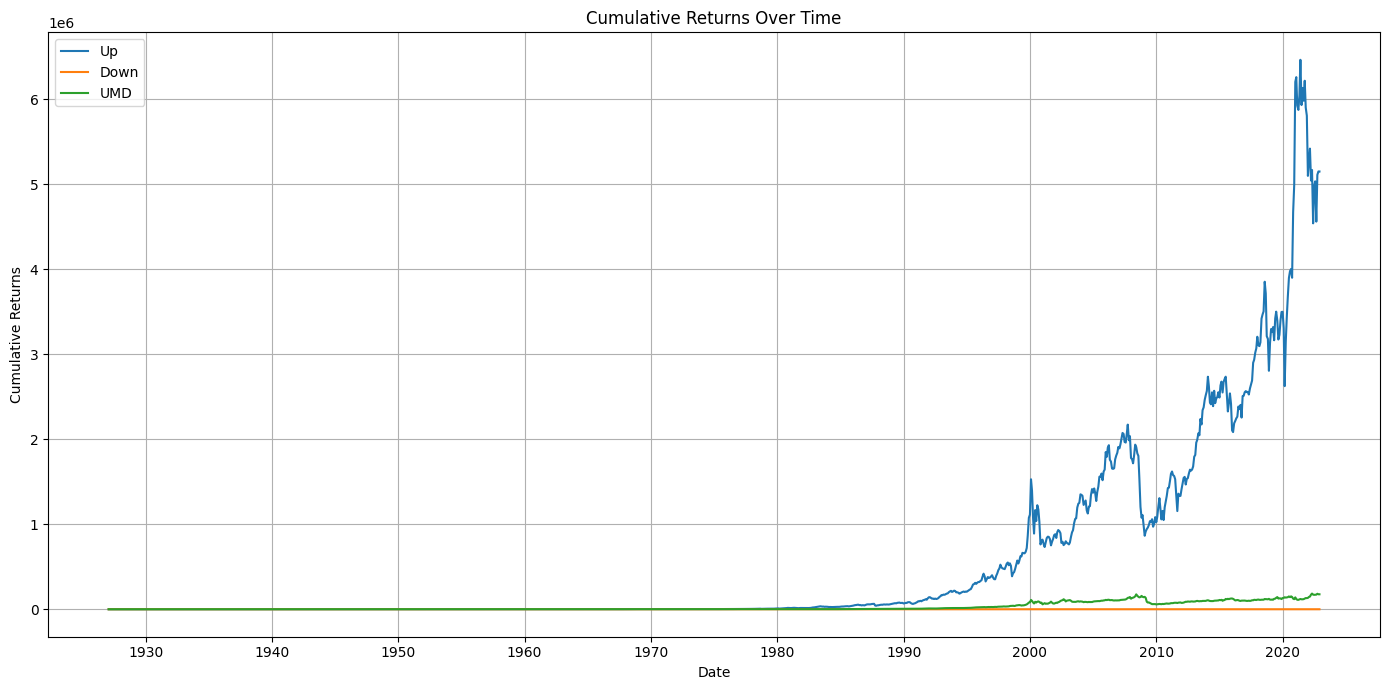

In [24]:
import matplotlib.dates as mdates


avg_1m_return_up = df_up.groupby('date')['future_return_1m'].mean().to_frame()
avg_1m_return_down = df_down.groupby('date')['future_return_1m'].mean().to_frame()
avg_1m_return_umd = avg_1m_return_up - avg_1m_return_down

avg_1m_return_up.index = pd.to_datetime(avg_1m_return_up.index)
avg_1m_return_down.index = pd.to_datetime(avg_1m_return_down.index)
avg_1m_return_umd.index = pd.to_datetime(avg_1m_return_umd.index)

# Calculate cumulative returns
avg_1m_return_up['cum_return_up'] = (1 + avg_1m_return_up['future_return_1m']).cumprod() - 1
avg_1m_return_down['cum_return_down'] = (1 + avg_1m_return_down['future_return_1m']).cumprod() - 1
avg_1m_return_umd['cum_return_umd'] = (1 + avg_1m_return_umd['future_return_1m']).cumprod() - 1

# Plot cumulative returns
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(avg_1m_return_up.index, avg_1m_return_up['cum_return_up'], label='Up')
ax.plot(avg_1m_return_down.index, avg_1m_return_down['cum_return_down'], label='Down')
ax.plot(avg_1m_return_umd.index, avg_1m_return_umd['cum_return_umd'], label='UMD')

# Set x-axis to display every 10 years
ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

In [25]:
# Resample the avg_1m_return_umd to annual frequency, summing the monthly returns
annual_returns_umd = (avg_1m_return_umd["future_return_1m"]+1).resample('A').prod() - 1
annual_returns_up = (avg_1m_return_up["future_return_1m"]+1).resample('A').prod() - 1

# Identify the years with the largest losses for the UMD strategy
worst_years = annual_returns_umd.nsmallest(5).index.year

# Analyze the behavior of the Up portfolio during the worst years
for year in worst_years:
    print(f'Year: {year}')
    print(f'UMD Return on this year: {annual_returns_umd.loc[annual_returns_umd.index.year == year].sum()}')
    print(f'Up Return on this year: {annual_returns_up.loc[annual_returns_up.index.year == year].sum()}')
    print()


Year: 2009
UMD Return on this year: -0.5986400821130684
Up Return on this year: 0.047311410725128455

Year: 1932
UMD Return on this year: -0.5654244509297137
Up Return on this year: -0.08780040609340478

Year: 1938
UMD Return on this year: -0.34387044010328083
Up Return on this year: 0.2372415983393572

Year: 2000
UMD Return on this year: -0.2882490956361673
Up Return on this year: -0.26481215098725075

Year: 1933
UMD Return on this year: -0.2687544703865973
Up Return on this year: 0.8980258836092967



In 2009, the one-month momentum strategy (UMD) incurred its largest loss, with a return of -0.5986. However, the Up portfolio, which represents stocks with strong momentum, had a positive return of 0.0473. This year was marked by the global financial crisis, and the discrepancy between the UMD and Up returns could be due to the sharp market rebound that followed the crisis, which might have benefited the Up portfolio.

The second-largest loss for the UMD strategy occurred in 1932, during the Great Depression, with a return of -0.5654. The Up portfolio also suffered a loss, with a return of -0.0878. Similarly, the third-largest loss for the UMD strategy was in 1938, another year during the Great Depression, with a return of -0.3439. However, in this case, the Up portfolio had a positive return of 0.2372.

In 2000, the UMD strategy had its fourth-largest loss, with a return of -0.2882. This was the year the dot-com bubble burst, and both the UMD and Up portfolios suffered losses, with the Up portfolio having a return of -0.2648.

The fifth-largest loss for the UMD strategy was in 1933, with a return of -0.2688. Interestingly, this was the year after the lowest point of the Great Depression, and the Up portfolio had a substantial gain, with a return of 0.8980.

Overall, it seems that the one-month momentum strategy tends to suffer losses during market downturns, such as the Great Depression and the financial crisis. However, the performance of the Up portfolio during these years varies, with positive returns in some cases and negative returns in others. This could be due to a variety of factors, such as changes in market conditions or the impact of other market participants reacting to the momentum effect.

In [26]:
# Calculate 3-year rolling window returns for the one-month strategy
rolling_return_3y = avg_1m_return_umd['future_return_1m'].rolling(window=36).sum()
rolling_return_3y.dropna(inplace=True)

# Calculate the percentage of 3-year overlapping periods with negative returns
negative_rolling_periods = (rolling_return_3y < 0).sum()
total_rolling_periods = len(rolling_return_3y)
percentage_negative = (negative_rolling_periods / total_rolling_periods) * 100

print(f'We have {total_rolling_periods} rolling periods in total while {negative_rolling_periods} of them are negative')
print(f'Percentage of 3-year overlapping periods with negative returns: {percentage_negative:.2f}%')


We have 1116 rolling periods in total while 111 of them are negative
Percentage of 3-year overlapping periods with negative returns: 9.95%


## Problem 0.3

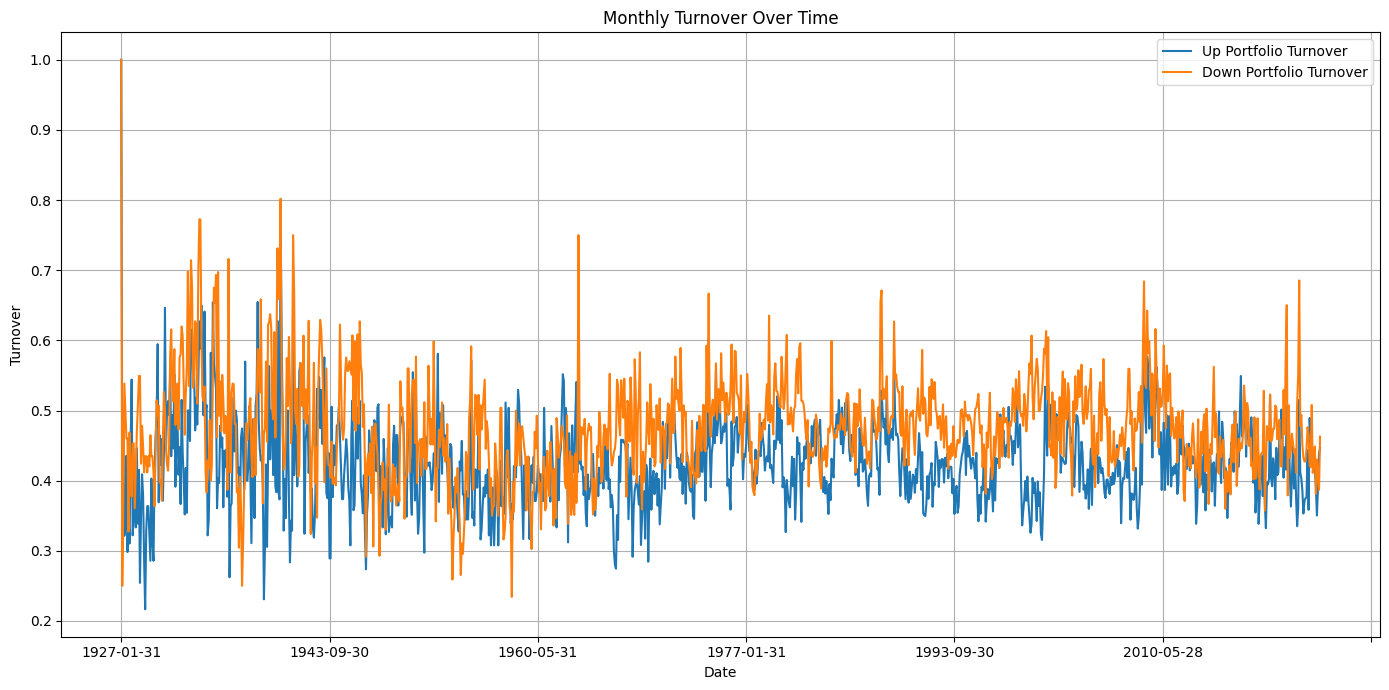

Average Turnover for Up Portfolio: 42.63%
Average Turnover for Down Portfolio: 47.63%


In [27]:
def calculate_turnover(portfolio_df):
    # Get the set of stocks for each month
    monthly_stocks = portfolio_df.groupby('date')['PERMNO'].apply(set)
    
    # Calculate turnover by comparing difference between sets for each month
    turnover = {}
    prev_stocks = set()
    for date, curr_stocks in monthly_stocks.items():
        if prev_stocks:
            turnover[date] = len(curr_stocks.symmetric_difference(prev_stocks)) / len(prev_stocks.union(curr_stocks))
        else:
            turnover[date] = 1.0
        prev_stocks = curr_stocks
        
    return pd.Series(turnover)

# Calculate turnover for UP and DOWN portfolios
up_df = df[df['decile_label'] == 'UP']
down_df = df[df['decile_label'] == 'DOWN']

turnover_up = calculate_turnover(up_df)
turnover_down = calculate_turnover(down_df)

# Plot turnover over time
plt.figure(figsize=(14,7))
turnover_up.plot(label='Up Portfolio Turnover')
turnover_down.plot(label='Down Portfolio Turnover')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.title('Monthly Turnover Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average turnover
print(f"Average Turnover for Up Portfolio: {turnover_up.mean() * 100:.2f}%")
print(f"Average Turnover for Down Portfolio: {turnover_down.mean() * 100:.2f}%")

The chart suggests that the one-month momentum strategy does have a relatively high turnover, especially considering that both the Up and Down portfolios experience average turnovers of 42.63% and 47.63% respectively. High turnover can significantly impact the actual performance of the strategy because frequent buying and selling can lead to increased transaction costs and potential tax implications. This could erode the net returns achieved by the strategy, making it imperative for investors to factor in these additional costs when assessing the strategy's viability.

Examining the turnover of the two portfolios, it seems that the turnover rates are not always consistent, showing fluctuations over time. However, the Down portfolio, on average, has a slightly higher turnover than the Up portfolio. Additionally, there are periods where both portfolios experience spikes in turnover, suggesting external events or market conditions prompting increased portfolio adjustments. The graph doesn't demonstrate a clear long-term upward or downward trend in turnover for either portfolio, but rather depicts periods of heightened activity followed by relative stability.

In [28]:
TRANSACTION_COST_RATE = 0.005  # 50 basis points

# Subtract the transaction costs from the monthly returns
avg_1m_return_up['return_up_net'] = avg_1m_return_up['future_return_1m'].values - turnover_up.values * TRANSACTION_COST_RATE
avg_1m_return_down['return_down_net'] = avg_1m_return_down['future_return_1m'].values - turnover_down.values * TRANSACTION_COST_RATE
avg_1m_return_umd['return_umd_net'] = avg_1m_return_umd['future_return_1m'].values - (turnover_up.values + turnover_down.values) * TRANSACTION_COST_RATE

In [29]:
from scipy.stats import ttest_1samp

t_stat_up, p_val_up = ttest_1samp(avg_1m_return_up['return_up_net'].dropna(), 0)
t_stat_down, p_val_down = ttest_1samp(avg_1m_return_down['return_down_net'].dropna(), 0)
t_stat_umd, p_val_umd = ttest_1samp(avg_1m_return_umd['return_umd_net'].dropna(), 0)

table_3 = {
    "Portfolio": ["Up", "Down", "UMD"],
    "Average Return Net of Transaction Costs": [
        avg_1m_return_up['return_up_net'].mean(),
        avg_1m_return_down['return_down_net'].mean(),
        avg_1m_return_umd['return_umd_net'].mean()
    ],
    "p-value": [p_val_up, p_val_down, p_val_umd]
}

print(pd.DataFrame(table_3))


  Portfolio  Average Return Net of Transaction Costs       p-value
0        Up                                 0.014069  8.431345e-11
1      Down                                 0.001182  6.572223e-01
2       UMD                                 0.008123  7.628539e-06


• Yes, the momentum strategy still earns positive abnormal returns after adjusting for transaction costs. This is evident from the positive "Average Return Net of Transaction Costs" for the UMD portfolio, which stands at 0.008123. The p-value also confirms the statistical significance of this positive abnormal return, as it's well below the common significance threshold of 0.05.

• To minimize transaction costs, the fund manager can consider a few modifications. Firstly, incorporating a buffer or threshold before rebalancing can be beneficial. This means the portfolio won't be adjusted with every slight change in momentum rankings but only when the momentum difference surpasses a certain threshold. This can reduce the frequency of trades and, consequently, transaction costs. Secondly, the manager could utilize more advanced order execution strategies, such as algorithmic trading, to optimize the trade execution process and achieve better price execution. This can help in reducing the slippage costs. Lastly, the fund manager could also look into negotiating lower trading fees with brokers or consider switching to platforms that offer lower transaction fees for high volume trades.

• Implementing a long-short momentum strategy poses various challenges for a fund manager. One primary concern is the potential for significant drawdowns or losses during market reversals. Given the nature of the strategy, which involves taking long positions in "winners" and short positions in "losers", sudden market reversals can lead to substantial losses. This requires diligent risk management, such as setting stop-loss limits or employing hedging techniques. Another challenge is the funding and margin requirements for short selling, as shorting stocks requires borrowing and can result in additional costs. The availability of stocks to short can also be an issue. A potential solution is to employ derivatives like futures or options as an alternative to direct short selling. Lastly, fund managers need to remain vigilant about the changing market dynamics and adapt the strategy accordingly. Continuous research, back-testing, and strategy refinement are essential to ensure the momentum strategy remains effective in varying market conditions.